## Govt. Bond 10 Years Yield

/tmp/ipykernel_8984/3394223850.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.set_index("date")["y_dec"].resample("M").last().dropna()


=== DETECTED COLUMNS ===
Date column : Date
Yield column: Closing

=== DATA SUMMARY ===
Range: 2016-01-04 to 2025-12-24
Obs  : 2467
Median yield (%): 6.906

=== SHOCK SUMMARY (bps) ===
    horizon  count  p95_up_bps  p99_up_bps  p05_down_bps  p01_down_bps  max_up_bps  max_down_bps
     native   2466        8.50      14.935        -9.075       -14.905        42.6         -49.0
monthly_eom    119       37.41      89.224       -51.930       -64.410       102.0         -73.5

=== WORST WINDOW (bps, monthly) ===
  horizon  worst_up_bps  worst_down_bps
 worst_1m         102.0           -73.5
 worst_3m         124.7          -106.7
 worst_6m         169.5          -133.3
worst_12m         179.6          -167.3


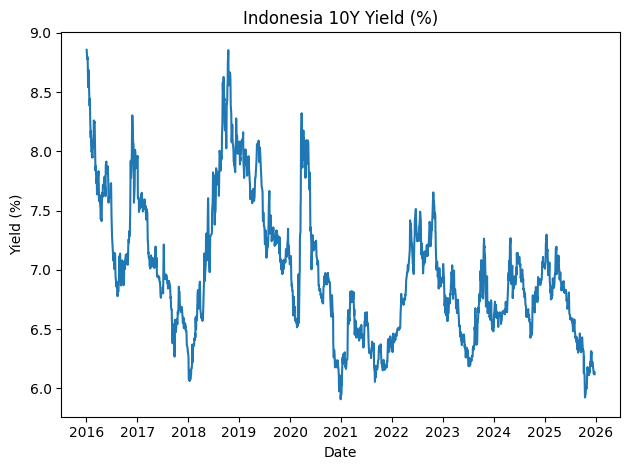

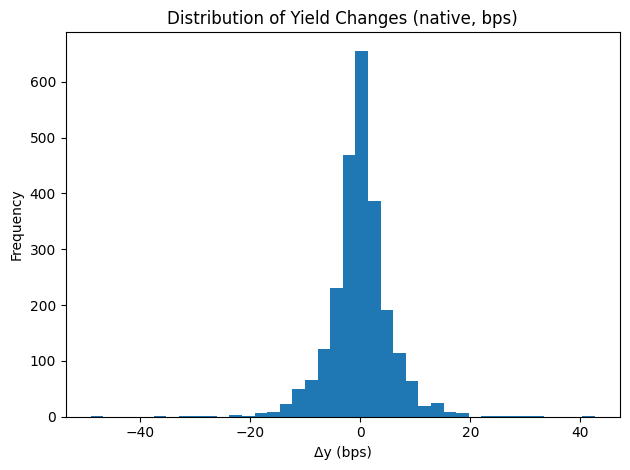

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


FILEPATH = "10 years yield.xlsx"
SHEET = 0  # first sheet; change if needed


# -------------------------
# Helpers
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    # fallback: choose the column with best datetime parse rate
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_yield_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("yield", "imbal", "hasil", "rate", "yld", "suku")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: choose most-numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a yield column. Please set YIELD_COL manually.")
    return best_col


def parse_yield_to_decimal(s: pd.Series) -> pd.Series:
    # handles '7,25', '7.25', '7.25%'
    x = s.astype(str).str.strip()
    x = x.str.replace("%", "", regex=False).str.replace(" ", "", regex=False)
    x = x.str.replace(r"(?<=\d),(?=\d)", ".", regex=True)  # decimal comma -> dot
    y = pd.to_numeric(x, errors="coerce")

    # scale to decimal if it's in percent
    # heuristic: if median > 1, assume percent like 7.25, convert to 0.0725
    if y.dropna().median() > 1:
        y = y / 100.0
    return y


def to_bps(delta_decimal: pd.Series) -> pd.Series:
    # 1 bp = 0.0001 in decimal rate
    return delta_decimal / 0.0001


def shock_table(delta_decimal: pd.Series, label: str) -> pd.DataFrame:
    d = delta_decimal.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up_bps": None, "p99_up_bps": None,
            "p05_down_bps": None, "p01_down_bps": None,
            "max_up_bps": None, "max_down_bps": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up_bps": float(to_bps(d.quantile(0.95))),
        "p99_up_bps": float(to_bps(d.quantile(0.99))),
        "p05_down_bps": float(to_bps(d.quantile(0.05))),
        "p01_down_bps": float(to_bps(d.quantile(0.01))),
        "max_up_bps": float(to_bps(d.max())),
        "max_down_bps": float(to_bps(d.min())),
    }])


# -------------------------
# Main processing
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
YIELD_COL = detect_yield_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, YIELD_COL]].copy()
df.columns = ["date", "y_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["y_dec"] = parse_yield_to_decimal(df["y_raw"])  # yield in decimal (e.g., 0.0725)

df = df.dropna(subset=["date", "y_dec"]).sort_values("date").reset_index(drop=True)
df["y_pct"] = df["y_dec"] * 100.0

# Native changes (daily/weekly depending on file)
df["dy_dec"] = df["y_dec"].diff()

# Monthly end-of-month series
m = df.set_index("date")["y_dec"].resample("M").last().dropna()
dm = m.diff()

# Worst k-month window (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    dk = m.diff(k).dropna()
    if dk.empty:
        worst_rows.append({"horizon": f"worst_{k}m", "worst_up_bps": None, "worst_down_bps": None})
    else:
        worst_rows.append({
            "horizon": f"worst_{k}m",
            "worst_up_bps": float(to_bps(dk.max())),
            "worst_down_bps": float(to_bps(dk.min()))
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summary tables
native_stats = shock_table(df["dy_dec"], "native")
monthly_stats = shock_table(dm, "monthly_eom")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Yield column:", YIELD_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Median yield (%):", round(df["y_pct"].median(), 4))

print("\n=== SHOCK SUMMARY (bps) ===")
print(summary.to_string(index=False))

print("\n=== WORST WINDOW (bps, monthly) ===")
print(worst_df.to_string(index=False))

# -------------------------
# Outputs (audit trail)
# -------------------------
df_out = df[["date", "y_pct", "y_dec"]].copy()
df_out.to_csv("10y_yield_clean.csv", index=False)
summary.to_csv("10y_yield_shock_summary.csv", index=False)
worst_df.to_csv("10y_yield_worst_windows.csv", index=False)

# -------------------------
# Plots
# -------------------------
plt.figure()
plt.plot(df["date"], df["y_pct"])
plt.title("Indonesia 10Y Yield (%)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(to_bps(df["dy_dec"].dropna()), bins=40)
plt.title("Distribution of Yield Changes (native, bps)")
plt.xlabel("Δy (bps)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Govt. Bond 5 Years Yield

/tmp/ipykernel_8984/135710266.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.set_index("date")["y_dec"].resample("M").last().dropna()


=== DETECTED COLUMNS ===
Date column : Date
Yield column: Closing

=== DATA SUMMARY ===
Range: 2016-01-04 to 2025-12-29
Obs  : 2471
Median yield (%): 6.559

=== SHOCK SUMMARY (bps) ===
    horizon  count  p95_up_bps  p99_up_bps  p05_down_bps  p01_down_bps  max_up_bps  max_down_bps
     native   2470       8.655      17.062         -8.80       -16.762        46.3         -42.9
monthly_eom    119      52.480     101.700        -49.82       -67.524       120.9         -78.3

=== WORST WINDOW (bps, monthly) ===
  horizon  worst_up_bps  worst_down_bps
 worst_1m         120.9           -78.3
 worst_3m         167.1          -133.0
 worst_6m         222.5          -167.4
worst_12m         211.6          -199.9


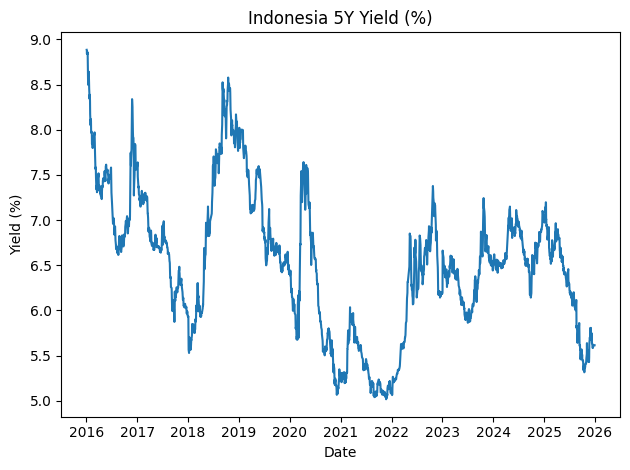

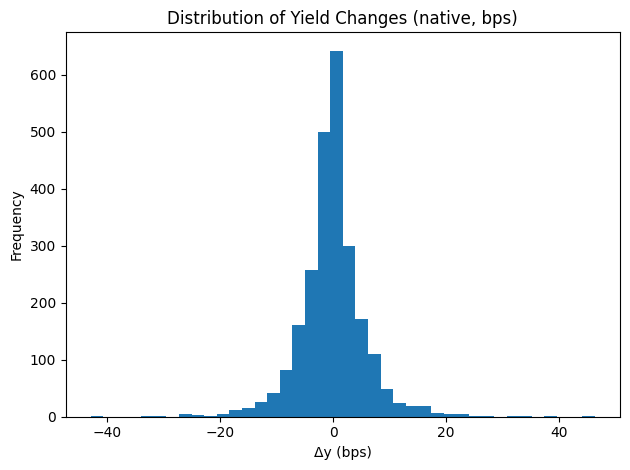

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


FILEPATH = "5Yyield.xlsx"
SHEET = 0  # first sheet; change if needed


# -------------------------
# Helpers
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    # fallback: choose the column with best datetime parse rate
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_yield_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("yield", "imbal", "hasil", "rate", "yld", "suku")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: choose most-numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a yield column. Please set YIELD_COL manually.")
    return best_col


def parse_yield_to_decimal(s: pd.Series) -> pd.Series:
    # handles '7,25', '7.25', '7.25%'
    x = s.astype(str).str.strip()
    x = x.str.replace("%", "", regex=False).str.replace(" ", "", regex=False)
    x = x.str.replace(r"(?<=\d),(?=\d)", ".", regex=True)  # decimal comma -> dot
    y = pd.to_numeric(x, errors="coerce")

    # scale to decimal if it's in percent
    # heuristic: if median > 1, assume percent like 7.25, convert to 0.0725
    if y.dropna().median() > 1:
        y = y / 100.0
    return y


def to_bps(delta_decimal: pd.Series) -> pd.Series:
    # 1 bp = 0.0001 in decimal rate
    return delta_decimal / 0.0001


def shock_table(delta_decimal: pd.Series, label: str) -> pd.DataFrame:
    d = delta_decimal.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up_bps": None, "p99_up_bps": None,
            "p05_down_bps": None, "p01_down_bps": None,
            "max_up_bps": None, "max_down_bps": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up_bps": float(to_bps(d.quantile(0.95))),
        "p99_up_bps": float(to_bps(d.quantile(0.99))),
        "p05_down_bps": float(to_bps(d.quantile(0.05))),
        "p01_down_bps": float(to_bps(d.quantile(0.01))),
        "max_up_bps": float(to_bps(d.max())),
        "max_down_bps": float(to_bps(d.min())),
    }])


# -------------------------
# Main processing
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
YIELD_COL = detect_yield_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, YIELD_COL]].copy()
df.columns = ["date", "y_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["y_dec"] = parse_yield_to_decimal(df["y_raw"])  # yield in decimal (e.g., 0.0725)

df = df.dropna(subset=["date", "y_dec"]).sort_values("date").reset_index(drop=True)
df["y_pct"] = df["y_dec"] * 100.0

# Native changes (daily/weekly depending on file)
df["dy_dec"] = df["y_dec"].diff()

# Monthly end-of-month series
m = df.set_index("date")["y_dec"].resample("M").last().dropna()
dm = m.diff()

# Worst k-month window (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    dk = m.diff(k).dropna()
    if dk.empty:
        worst_rows.append({"horizon": f"worst_{k}m", "worst_up_bps": None, "worst_down_bps": None})
    else:
        worst_rows.append({
            "horizon": f"worst_{k}m",
            "worst_up_bps": float(to_bps(dk.max())),
            "worst_down_bps": float(to_bps(dk.min()))
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summary tables
native_stats = shock_table(df["dy_dec"], "native")
monthly_stats = shock_table(dm, "monthly_eom")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Yield column:", YIELD_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Median yield (%):", round(df["y_pct"].median(), 4))

print("\n=== SHOCK SUMMARY (bps) ===")
print(summary.to_string(index=False))

print("\n=== WORST WINDOW (bps, monthly) ===")
print(worst_df.to_string(index=False))

# -------------------------
# Outputs (audit trail)
# -------------------------
df_out = df[["date", "y_pct", "y_dec"]].copy()
df_out.to_csv("5y_yield_clean.csv", index=False)
summary.to_csv("5y_yield_shock_summary.csv", index=False)
worst_df.to_csv("5y_yield_worst_windows.csv", index=False)

# -------------------------
# Plots
# -------------------------
plt.figure()
plt.plot(df["date"], df["y_pct"])
plt.title("Indonesia 5Y Yield (%)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(to_bps(df["dy_dec"].dropna()), bins=40)
plt.title("Distribution of Yield Changes (native, bps)")
plt.xlabel("Δy (bps)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## IHSG 10 Years

=== DETECTED COLUMNS ===
Date column : Date
Index column: Closing

=== DATA SUMMARY ===
Range: 2016-01-04 to 2025-12-29
Obs  : 2417
Last index level: 8644.26

=== SHOCK SUMMARY (returns) ===
            horizon  count p95_up p99_up p05_down p01_down max_up max_down
native_daily_return   2416  1.43%  2.33%   -1.43%   -2.59% 10.19%   -7.90%
 monthly_eom_return    119  5.75%  7.81%   -5.74%  -11.15%  9.44%  -16.76%

=== WORST WINDOW (cumulative return, monthly) ===
window worst_up worst_down
    1M    9.44%    -16.76%
    3M   22.77%    -27.95%
    6M   24.88%    -26.42%
   12M   31.87%    -29.83%


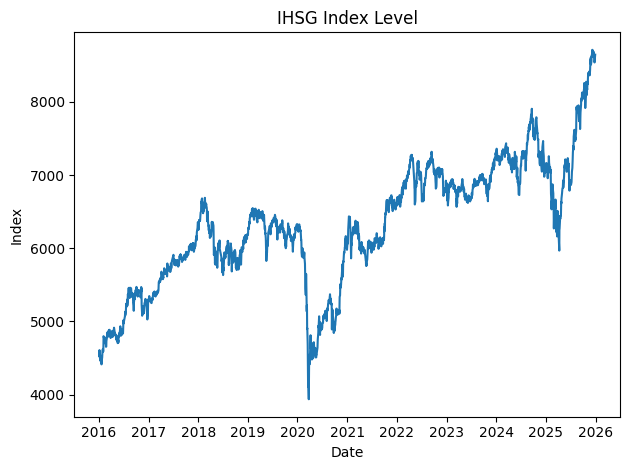

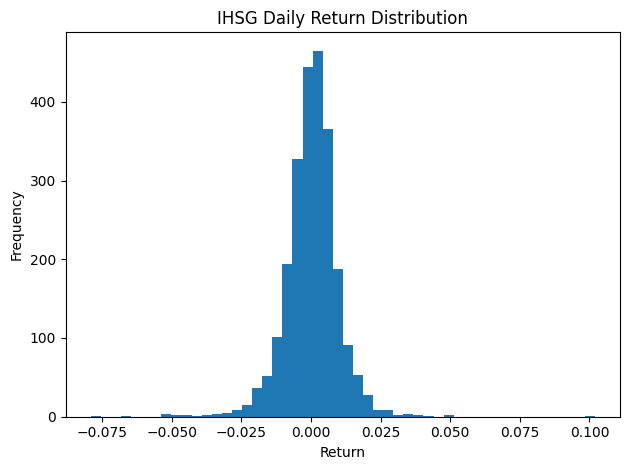


Saved: IHSG_clean.csv, IHSG_shock_summary.csv, IHSG_worst_windows.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

FILEPATH = "IHSG10years.xlsx"   # if in same folder as notebook
SHEET = 0                       # first sheet


# -------------------------
# Helpers (same idea as before)
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_price_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("close", "closing", "price", "last", "ihsg", "index", "nilai")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: most numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a price/index column. Please set PRICE_COL manually.")
    return best_col


def parse_numeric(series: pd.Series) -> pd.Series:
    x = series.astype(str).str.strip()
    x = x.str.replace(",", "", regex=False)  # remove thousands separators (common)
    x = x.str.replace(" ", "", regex=False)
    return pd.to_numeric(x, errors="coerce")


def shock_table(delta: pd.Series, label: str) -> pd.DataFrame:
    d = delta.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up": None, "p99_up": None,
            "p05_down": None, "p01_down": None,
            "max_up": None, "max_down": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up": float(d.quantile(0.95)),
        "p99_up": float(d.quantile(0.99)),
        "p05_down": float(d.quantile(0.05)),
        "p01_down": float(d.quantile(0.01)),
        "max_up": float(d.max()),
        "max_down": float(d.min()),
    }])


def pct(x: float) -> str:
    return f"{100*x:.2f}%"


# -------------------------
# Main
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
PRICE_COL = detect_price_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, PRICE_COL]].copy()
df.columns = ["date", "px_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["px"] = parse_numeric(df["px_raw"])

df = df.dropna(subset=["date", "px"]).sort_values("date").reset_index(drop=True)

# Returns (log return is optional; simple return is usually enough for CP)
df["ret"] = df["px"].pct_change()

# Monthly end-of-month (EOM) prices + returns
m_px = df.set_index("date")["px"].resample("ME").last().dropna()
m_ret = m_px.pct_change()

# Worst k-month window cumulative returns (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    cum_ret_k = (m_px / m_px.shift(k)) - 1
    cum_ret_k = cum_ret_k.dropna()
    if cum_ret_k.empty:
        worst_rows.append({"window": f"{k}M", "worst_up": None, "worst_down": None})
    else:
        worst_rows.append({
            "window": f"{k}M",
            "worst_up": float(cum_ret_k.max()),
            "worst_down": float(cum_ret_k.min())
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summaries
native_stats = shock_table(df["ret"], "native_daily_return")
monthly_stats = shock_table(m_ret, "monthly_eom_return")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

# Print
print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Index column:", PRICE_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Last index level:", float(df["px"].iloc[-1]))

print("\n=== SHOCK SUMMARY (returns) ===")
# pretty print as %
summary_fmt = summary.copy()
for c in ["p95_up", "p99_up", "p05_down", "p01_down", "max_up", "max_down"]:
    summary_fmt[c] = summary_fmt[c].apply(lambda v: pct(v) if pd.notna(v) else None)
print(summary_fmt.to_string(index=False))

print("\n=== WORST WINDOW (cumulative return, monthly) ===")
worst_fmt = worst_df.copy()
worst_fmt["worst_up"] = worst_fmt["worst_up"].apply(lambda v: pct(v) if pd.notna(v) else None)
worst_fmt["worst_down"] = worst_fmt["worst_down"].apply(lambda v: pct(v) if pd.notna(v) else None)
print(worst_fmt.to_string(index=False))

# Optional plots
plt.figure()
plt.plot(df["date"], df["px"])
plt.title("IHSG Index Level")
plt.xlabel("Date")
plt.ylabel("Index")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df["ret"].dropna(), bins=50)
plt.title("IHSG Daily Return Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional exports (save to current folder)
df[["date", "px", "ret"]].to_csv("IHSG_clean.csv", index=False)
summary.to_csv("IHSG_shock_summary.csv", index=False)
worst_df.to_csv("IHSG_worst_windows.csv", index=False)

print("\nSaved: IHSG_clean.csv, IHSG_shock_summary.csv, IHSG_worst_windows.csv")

## Corp. Bond Rate 5 Years

=== DETECTED COLUMNS ===
Date column : Date
Yield column: Closing

=== DATA SUMMARY ===
Range: 2016-01-01 to 2025-12-29
Obs  : 3651
Median yield (%): 7.9056

=== SHOCK SUMMARY (bps) ===
    horizon  count  p95_up_bps  p99_up_bps  p05_down_bps  p01_down_bps  max_up_bps  max_down_bps
     native   3650      4.3555      9.5324        -4.690       -9.5212       52.49        -29.97
monthly_eom    119     35.5750     93.8312       -40.631      -46.5370      120.28        -55.35

=== WORST WINDOW (bps, monthly) ===
  horizon  worst_up_bps  worst_down_bps
 worst_1m        120.28          -55.35
 worst_3m        138.07         -113.87
 worst_6m        169.30         -132.11
worst_12m        163.50         -189.17


/tmp/ipykernel_8984/2572129959.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.set_index("date")["y_dec"].resample("M").last().dropna()


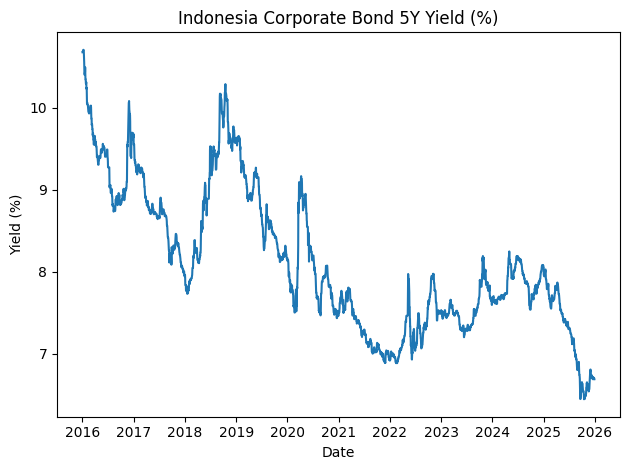

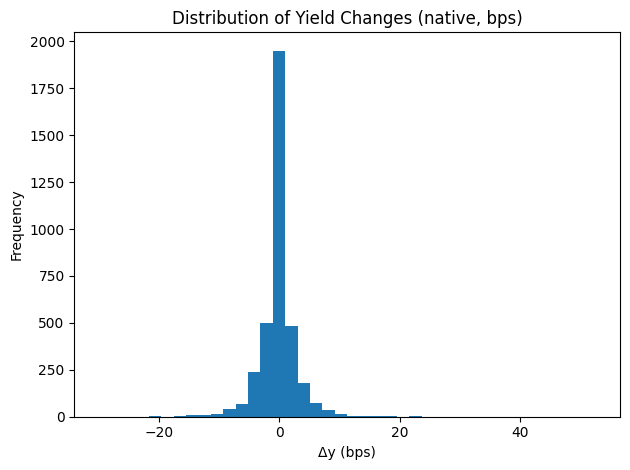

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


FILEPATH = "Corp5Y.xlsx"
SHEET = 0  # first sheet; change if needed


# -------------------------
# Helpers
# -------------------------
def detect_date_col(df: pd.DataFrame) -> str:
    keywords = ("date", "tanggal", "time", "periode", "period")
    for c in df.columns:
        if isinstance(c, str) and any(k in c.lower() for k in keywords):
            return c
    # fallback: choose the column with best datetime parse rate
    best_col, best_rate = None, 0
    for c in df.columns:
        parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        rate = parsed.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a date column. Please set DATE_COL manually.")
    return best_col


def detect_yield_col(df: pd.DataFrame, date_col: str) -> str:
    keywords = ("yield", "imbal", "hasil", "rate", "yld", "suku")
    candidates = [
        c for c in df.columns
        if c != date_col and isinstance(c, str) and any(k in c.lower() for k in keywords)
    ]
    if candidates:
        return candidates[0]
    # fallback: choose most-numeric column excluding date
    best_col, best_rate = None, 0
    for c in df.columns:
        if c == date_col:
            continue
        s = pd.to_numeric(df[c], errors="coerce")
        rate = s.notna().mean()
        if rate > best_rate:
            best_col, best_rate = c, rate
    if best_col is None or best_rate < 0.3:
        raise ValueError("Could not detect a yield column. Please set YIELD_COL manually.")
    return best_col


def parse_yield_to_decimal(s: pd.Series) -> pd.Series:
    # handles '7,25', '7.25', '7.25%'
    x = s.astype(str).str.strip()
    x = x.str.replace("%", "", regex=False).str.replace(" ", "", regex=False)
    x = x.str.replace(r"(?<=\d),(?=\d)", ".", regex=True)  # decimal comma -> dot
    y = pd.to_numeric(x, errors="coerce")

    # scale to decimal if it's in percent
    # heuristic: if median > 1, assume percent like 7.25, convert to 0.0725
    if y.dropna().median() > 1:
        y = y / 100.0
    return y


def to_bps(delta_decimal: pd.Series) -> pd.Series:
    # 1 bp = 0.0001 in decimal rate
    return delta_decimal / 0.0001


def shock_table(delta_decimal: pd.Series, label: str) -> pd.DataFrame:
    d = delta_decimal.dropna()
    if d.empty:
        return pd.DataFrame([{
            "horizon": label, "count": 0,
            "p95_up_bps": None, "p99_up_bps": None,
            "p05_down_bps": None, "p01_down_bps": None,
            "max_up_bps": None, "max_down_bps": None
        }])

    return pd.DataFrame([{
        "horizon": label,
        "count": int(d.shape[0]),
        "p95_up_bps": float(to_bps(d.quantile(0.95))),
        "p99_up_bps": float(to_bps(d.quantile(0.99))),
        "p05_down_bps": float(to_bps(d.quantile(0.05))),
        "p01_down_bps": float(to_bps(d.quantile(0.01))),
        "max_up_bps": float(to_bps(d.max())),
        "max_down_bps": float(to_bps(d.min())),
    }])


# -------------------------
# Main processing
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

DATE_COL = detect_date_col(df_raw)
YIELD_COL = detect_yield_col(df_raw, DATE_COL)

df = df_raw[[DATE_COL, YIELD_COL]].copy()
df.columns = ["date", "y_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["y_dec"] = parse_yield_to_decimal(df["y_raw"])  # yield in decimal (e.g., 0.0725)

df = df.dropna(subset=["date", "y_dec"]).sort_values("date").reset_index(drop=True)
df["y_pct"] = df["y_dec"] * 100.0

# Native changes (daily/weekly depending on file)
df["dy_dec"] = df["y_dec"].diff()

# Monthly end-of-month series
m = df.set_index("date")["y_dec"].resample("M").last().dropna()
dm = m.diff()

# Worst k-month window (monthly)
worst_rows = []
for k in [1, 3, 6, 12]:
    dk = m.diff(k).dropna()
    if dk.empty:
        worst_rows.append({"horizon": f"worst_{k}m", "worst_up_bps": None, "worst_down_bps": None})
    else:
        worst_rows.append({
            "horizon": f"worst_{k}m",
            "worst_up_bps": float(to_bps(dk.max())),
            "worst_down_bps": float(to_bps(dk.min()))
        })
worst_df = pd.DataFrame(worst_rows)

# Shock summary tables
native_stats = shock_table(df["dy_dec"], "native")
monthly_stats = shock_table(dm, "monthly_eom")
summary = pd.concat([native_stats, monthly_stats], ignore_index=True)

print("=== DETECTED COLUMNS ===")
print("Date column :", DATE_COL)
print("Yield column:", YIELD_COL)

print("\n=== DATA SUMMARY ===")
print("Range:", df["date"].min().date(), "to", df["date"].max().date())
print("Obs  :", len(df))
print("Median yield (%):", round(df["y_pct"].median(), 4))

print("\n=== SHOCK SUMMARY (bps) ===")
print(summary.to_string(index=False))

print("\n=== WORST WINDOW (bps, monthly) ===")
print(worst_df.to_string(index=False))

# -------------------------
# Outputs (audit trail)
# -------------------------
df_out = df[["date", "y_pct", "y_dec"]].copy()
df_out.to_csv("5yCorp_yield_clean.csv", index=False)
summary.to_csv("5yCorp_yield_shock_summary.csv", index=False)
worst_df.to_csv("5yCorp_yield_worst_windows.csv", index=False)

# -------------------------
# Plots
# -------------------------
plt.figure()
plt.plot(df["date"], df["y_pct"])
plt.title("Indonesia Corporate Bond 5Y Yield (%)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(to_bps(df["dy_dec"].dropna()), bins=40)
plt.title("Distribution of Yield Changes (native, bps)")
plt.xlabel("Δy (bps)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## BI Rate 

=== BI RATE DATA SUMMARY (MONTHLY EOM) ===
Range: 2016-03-31 to 2025-12-31
Last BI rate (%): 4.75
Median BI rate (%): 5.0

=== MONTHLY BI RATE SHOCKS (bps) ===
horizon  count  p95_up_bps  p99_up_bps  p05_down_bps  p01_down_bps  max_up_bps  max_down_bps
monthly    117        25.0        50.0         -25.0         -25.0        50.0         -25.0

=== WORST CUMULATIVE TIGHTENING (bps) ===
window  worst_up_bps  worst_down_bps
    1M          50.0           -25.0
    3M         150.0           -75.0
    6M         225.0          -100.0
   12M         225.0          -175.0


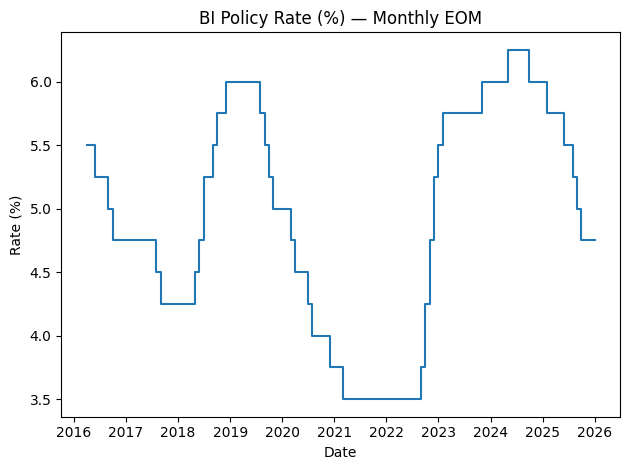

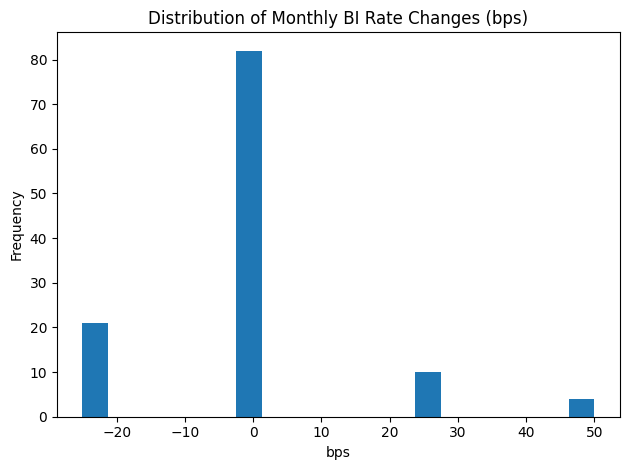


Saved: BI_rate_clean.csv, BI_rate_shock_summary.csv, BI_rate_worst_windows.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

FILEPATH = "BI_rate.xlsx"
SHEET = 0

# Adjust if needed
DATE_COL = "Date"
RATE_COL = "BI_Rate"


def parse_rate_to_percent(series: pd.Series) -> pd.Series:
    """
    Returns a numeric Series in PERCENT units (e.g., 6.25 means 6.25%).
    Handles: '6,25', '6.25%', '0.0625' (decimal), '625' (bps) heuristically.
    """
    x = series.astype(str).str.strip()
    x = x.str.replace("%", "", regex=False)
    x = x.str.replace(" ", "", regex=False)

    # If the source uses comma as decimal separator
    x = x.str.replace(r"(?<=\d),(?=\d)", ".", regex=True)

    y = pd.to_numeric(x, errors="coerce")

    # Heuristics to normalise units:
    # - If median is between 0 and 1: likely decimal (0.0625), convert to percent
    # - If median is very large (e.g., > 100): likely bps (625), convert to percent
    med = y.dropna().median()
    if pd.notna(med):
        if 0 < med < 1:
            y = y * 100.0
        elif med > 100:
            y = y / 100.0

    return y


# -------------------------
# Load & clean
# -------------------------
df_raw = pd.read_excel(FILEPATH, sheet_name=SHEET)

if DATE_COL not in df_raw.columns or RATE_COL not in df_raw.columns:
    raise ValueError(f"Columns not found. Available columns: {df_raw.columns.tolist()}")

df = df_raw[[DATE_COL, RATE_COL]].copy()
df.columns = ["date", "rate_raw"]

df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["y_pct"] = parse_rate_to_percent(df["rate_raw"])

df = df.dropna(subset=["date", "y_pct"]).sort_values("date")

# -------------------------
# MONTH-END alignment (recommended for policy rates)
# -------------------------
# Make a clean monthly end-of-month level series
m = df.set_index("date")["y_pct"].resample("ME").last().dropna()

# Rebuild a monthly dataframe
df_m = m.reset_index()
df_m.columns = ["date", "y_pct"]

# Month-to-month changes in bps (1% = 100 bps)
df_m["d_rate_bps"] = df_m["y_pct"].diff() * 100.0

# -------------------------
# Shock summary (monthly, bps)
# -------------------------
def shock_table_bps(delta_bps: pd.Series, label: str) -> pd.DataFrame:
    d = delta_bps.dropna()
    return pd.DataFrame([{
        "horizon": label,
        "count": int(len(d)),
        "p95_up_bps": float(d.quantile(0.95)),
        "p99_up_bps": float(d.quantile(0.99)),
        "p05_down_bps": float(d.quantile(0.05)),
        "p01_down_bps": float(d.quantile(0.01)),
        "max_up_bps": float(d.max()),
        "max_down_bps": float(d.min()),
    }])

monthly_stats = shock_table_bps(df_m["d_rate_bps"], "monthly")

# -------------------------
# Worst cumulative tightening (bps)
# -------------------------
worst_rows = []
for k in [1, 3, 6, 12]:
    cum_bps = df_m["d_rate_bps"].rolling(k).sum()
    worst_rows.append({
        "window": f"{k}M",
        "worst_up_bps": float(cum_bps.max()),
        "worst_down_bps": float(cum_bps.min())
    })
worst_df = pd.DataFrame(worst_rows)

# -------------------------
# Prints
# -------------------------
print("=== BI RATE DATA SUMMARY (MONTHLY EOM) ===")
print("Range:", df_m["date"].min().date(), "to", df_m["date"].max().date())
print("Last BI rate (%):", float(df_m["y_pct"].iloc[-1]))
print("Median BI rate (%):", float(df_m["y_pct"].median()))

print("\n=== MONTHLY BI RATE SHOCKS (bps) ===")
print(monthly_stats.to_string(index=False))

print("\n=== WORST CUMULATIVE TIGHTENING (bps) ===")
print(worst_df.to_string(index=False))

# -------------------------
# Plots
# -------------------------
plt.figure()
plt.step(df_m["date"], df_m["y_pct"], where="post")
plt.title("BI Policy Rate (%) — Monthly EOM")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df_m["d_rate_bps"].dropna(), bins=20)
plt.title("Distribution of Monthly BI Rate Changes (bps)")
plt.xlabel("bps")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------
# Exports (compatible with your combined chart code)
# -------------------------
df_m[["date", "y_pct"]].to_csv("BI_rate_clean.csv", index=False)
monthly_stats.to_csv("BI_rate_shock_summary.csv", index=False)
worst_df.to_csv("BI_rate_worst_windows.csv", index=False)

print("\nSaved: BI_rate_clean.csv, BI_rate_shock_summary.csv, BI_rate_worst_windows.csv")


## Combined Graph

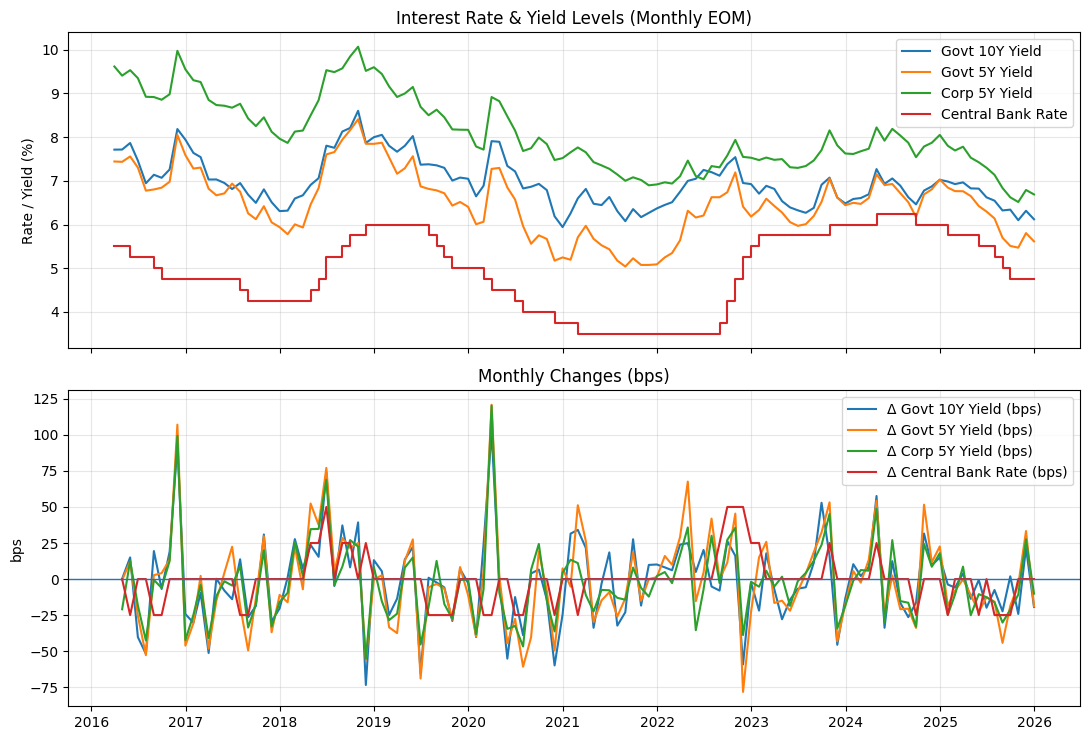

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# INPUT FILES (EDIT HERE)
# =========================
GOV10Y_CSV = "10y_yield_clean.csv"        # columns: date, y_pct
GOV5Y_CSV  = "5y_yield_clean.csv"         # columns: date, y_pct
CORP5Y_CSV = "5yCorp_yield_clean.csv"     # columns: date, y_pct
BI_CSV     = "BI_rate_clean.csv"          # columns: date, y_pct

NAME_GOV10Y = "Govt 10Y Yield"
NAME_GOV5Y  = "Govt 5Y Yield"
NAME_CORP5Y = "Corp 5Y Yield"
NAME_BI     = "Central Bank Rate"


def load_rate_series(path: str, date_col="date", y_col="y_pct") -> pd.Series:
    df = pd.read_csv(path)

    # Basic validation
    if date_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"{path}: expected columns '{date_col}' and '{y_col}'. Found {df.columns.tolist()}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")

    s = pd.Series(y.values, index=df[date_col]).dropna().sort_index()

    # Align to month-end for consistent comparison
    s = s.resample("ME").last().dropna()

    return s


# =========================
# LOAD SERIES
# =========================
gov10 = load_rate_series(GOV10Y_CSV).rename(NAME_GOV10Y)
gov5  = load_rate_series(GOV5Y_CSV).rename(NAME_GOV5Y)
corp5 = load_rate_series(CORP5Y_CSV).rename(NAME_CORP5Y)
bi    = load_rate_series(BI_CSV).rename(NAME_BI)

# Combine (keep only overlapping dates to avoid gaps)
combo = pd.concat([gov10, gov5, corp5, bi], axis=1).dropna()

# Monthly changes in bps (1% = 100 bps)
chg_bps = combo.diff() * 100.0

# =========================
# PLOT
# =========================
fig, axes = plt.subplots(2, 1, figsize=(11, 7.5), sharex=True)

# Panel A: levels
axes[0].plot(combo.index, combo[NAME_GOV10Y], label=NAME_GOV10Y)
axes[0].plot(combo.index, combo[NAME_GOV5Y],  label=NAME_GOV5Y)
axes[0].plot(combo.index, combo[NAME_CORP5Y], label=NAME_CORP5Y)
axes[0].step(combo.index, combo[NAME_BI], where="post", label=NAME_BI)  # policy rate is step-like

axes[0].set_title("Interest Rate & Yield Levels (Monthly EOM)")
axes[0].set_ylabel("Rate / Yield (%)")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="best")

# Panel B: changes
axes[1].plot(chg_bps.index, chg_bps[NAME_GOV10Y], label=f"Δ {NAME_GOV10Y} (bps)")
axes[1].plot(chg_bps.index, chg_bps[NAME_GOV5Y],  label=f"Δ {NAME_GOV5Y} (bps)")
axes[1].plot(chg_bps.index, chg_bps[NAME_CORP5Y], label=f"Δ {NAME_CORP5Y} (bps)")
axes[1].plot(chg_bps.index, chg_bps[NAME_BI],     label=f"Δ {NAME_BI} (bps)")

axes[1].axhline(0, linewidth=1)
axes[1].set_title("Monthly Changes (bps)")
axes[1].set_ylabel("bps")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

# =========================
# EXPORTS
# =========================
combo.to_csv("rates_levels_monthly.csv", index=True)
chg_bps.to_csv("rates_changes_bps_monthly.csv", index=True)


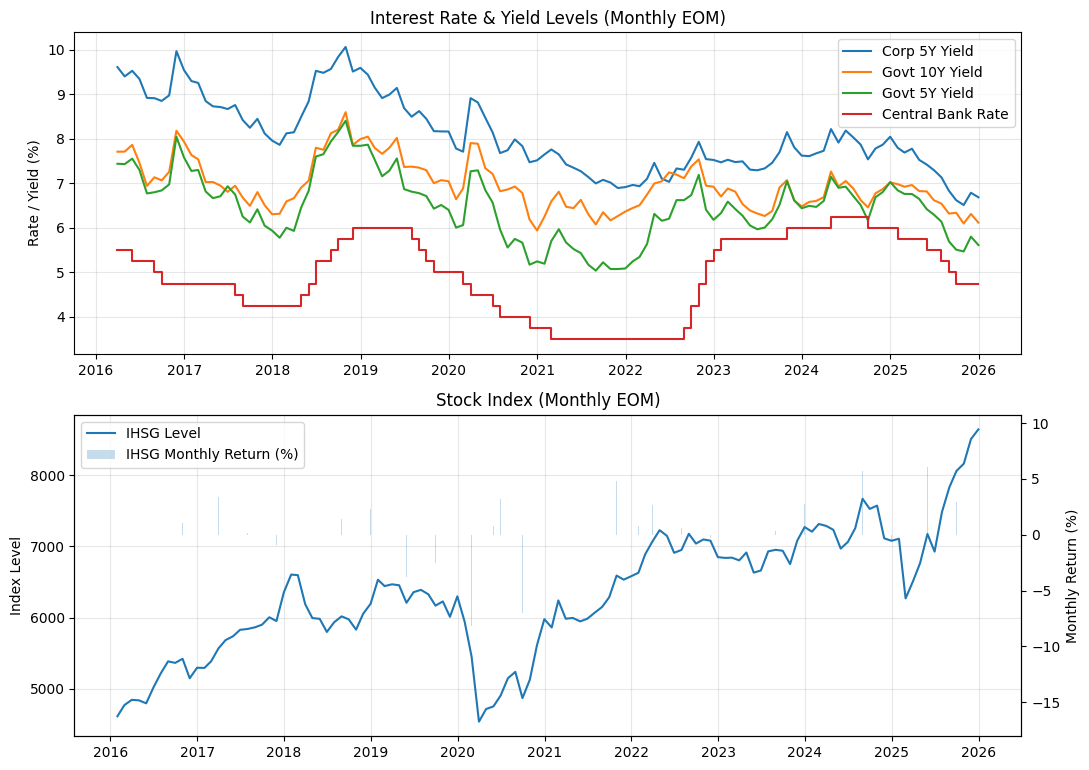

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# INPUT FILES (EDIT HERE)
# =========================
# Rates / yields (must contain columns: date, y_pct)
GOV10Y_CSV = "10y_yield_clean.csv"
GOV5Y_CSV  = "5y_yield_clean.csv"
CORP5Y_CSV = "5yCorp_yield_clean.csv"
BI_CSV     = "BI_rate_clean.csv"

# Stock index (must contain columns: date, px_col)
IHSG_CSV   = "IHSG_clean.csv"
IHSG_PX_COL = "px"   # change to your actual column name if different (e.g. "Closing", "index_level")

# Series names (for legends)
NAME_GOV10Y = "Govt 10Y Yield"
NAME_GOV5Y  = "Govt 5Y Yield"
NAME_CORP5Y = "Corp 5Y Yield"
NAME_BI     = "Central Bank Rate"
NAME_IHSG   = "IHSG"

# Behaviour toggles
OVERLAP_ONLY = True          # True: restrict to overlapping dates for panel 1
SHOW_IHSG_RETURN = True      # True: show IHSG monthly return on a second axis in panel 2


# =========================
# HELPERS
# =========================
def load_rate_series(path: str, name: str, date_col="date", y_col="y_pct") -> pd.Series:
    """Load a rate/yield series in percent units and resample to month-end."""
    df = pd.read_csv(path)

    if date_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"{path}: expected columns '{date_col}' and '{y_col}'. Found {df.columns.tolist()}")

    df = df[[date_col, y_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[y_col] = pd.to_numeric(df[y_col], errors="coerce")
    df = df.dropna(subset=[date_col, y_col]).sort_values(date_col)

    # Deduplicate on date (keep last)
    df = df.drop_duplicates(subset=[date_col], keep="last")

    s = pd.Series(df[y_col].values, index=df[date_col], name=name).sort_index()
    s = s.resample("ME").last().dropna()  # month-end
    return s


def load_index_series(path: str, name: str, date_col="date", px_col="px") -> pd.Series:
    """Load an index level series and resample to month-end."""
    df = pd.read_csv(path)

    if date_col not in df.columns or px_col not in df.columns:
        raise ValueError(f"{path}: expected columns '{date_col}' and '{px_col}'. Found {df.columns.tolist()}")

    df = df[[date_col, px_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[px_col] = pd.to_numeric(df[px_col], errors="coerce")
    df = df.dropna(subset=[date_col, px_col]).sort_values(date_col)

    # Deduplicate on date (keep last)
    df = df.drop_duplicates(subset=[date_col], keep="last")

    s = pd.Series(df[px_col].values, index=df[date_col], name=name).sort_index()
    s = s.resample("ME").last().dropna()  # month-end
    return s


# =========================
# LOAD SERIES
# =========================
gov10 = load_rate_series(GOV10Y_CSV, NAME_GOV10Y)
gov5  = load_rate_series(GOV5Y_CSV,  NAME_GOV5Y)
corp5 = load_rate_series(CORP5Y_CSV, NAME_CORP5Y)
bi    = load_rate_series(BI_CSV,     NAME_BI)

ihsg  = load_index_series(IHSG_CSV, NAME_IHSG, px_col=IHSG_PX_COL)
ihsg_ret = ihsg.pct_change() * 100.0  # monthly return in %

# Panel 1 dataset (rates/yields)
rates = pd.concat([gov10, gov5, corp5, bi], axis=1)

if OVERLAP_ONLY:
    rates = rates.dropna()
else:
    # Keep full history with NaNs (plots will show gaps)
    pass

# =========================
# PLOT
# =========================
fig, axes = plt.subplots(2, 1, figsize=(11, 7.8), sharex=False)

# -------------------------
# Panel 1: rates/yields levels
# -------------------------
axes[0].plot(rates.index, rates[NAME_CORP5Y], label=NAME_CORP5Y)
axes[0].plot(rates.index, rates[NAME_GOV10Y], label=NAME_GOV10Y)
axes[0].plot(rates.index, rates[NAME_GOV5Y],  label=NAME_GOV5Y)
axes[0].step(rates.index, rates[NAME_BI], where="post", label=NAME_BI)  # policy rate is step-like

axes[0].set_title("Interest Rate & Yield Levels (Monthly EOM)")
axes[0].set_ylabel("Rate / Yield (%)")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="best")

# -------------------------
# Panel 2: stock index (level + optional return)
# -------------------------
ax1 = axes[1]
ax1.plot(ihsg.index, ihsg.values, label=f"{NAME_IHSG} Level")
ax1.set_title("Stock Index (Monthly EOM)")
ax1.set_ylabel("Index Level")
ax1.grid(True, alpha=0.3)

if SHOW_IHSG_RETURN:
    ax2 = ax1.twinx()
    ax2.bar(ihsg_ret.index, ihsg_ret.values, alpha=0.25, label=f"{NAME_IHSG} Monthly Return (%)")
    ax2.set_ylabel("Monthly Return (%)")

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
else:
    ax1.legend(loc="best")

plt.tight_layout()
plt.show()

# =========================
# EXPORTS (optional)
# =========================
rates.to_csv("rates_levels_monthly.csv", index=True)
ihsg.to_frame("ihsg_level").to_csv("ihsg_monthly_level.csv", index=True)
ihsg_ret.to_frame("ihsg_monthly_return_pct").to_csv("ihsg_monthly_return_pct.csv", index=True)
